In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib


from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions, template_creator

from ATARI.models.particle_pair import Particle_Pair
from ATARI.models.experimental_model import experimental_model

from copy import copy


In [2]:
%matplotlib widget

In [3]:
def plot(datasets, experiments, fits, priors=[]):
    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=(10,7), sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=colors[i], linewidth=0.5, markersize=1.5, capsize=1, label=exp.title)
        
        axes[iax].plot(fits[i].E, fits[i][model_key], color=colors[i], lw=1.5, label=f'fit {exp.title}')

        if len(priors) != 0:
            axes[iax].plot(fits[i].E, priors[i][model_key], '--', color=colors[i], lw=1.5) #, label=f'prior {exp.title}')
        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        ax.set_ylim([-0.1,1.1])
        ax.legend()

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

In [4]:
sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    sammy_runDIR = 'SAMMY_runDIR',
    keep_runDIR = True,
    shell = 'zsh',
    inptemplate= "readendf.inp",
    )

matnum = 7328
jeff_file = "/Users/noahwalton/research_local/data/JEFF33_endf6/73-Ta-181g.jeff33"
endf_file = "/Users/noahwalton/research_local/data/neutrons_ENDF-B-VII.1/n-073_Ta_181.endf"

endf_parameters = sammy_functions.get_endf_parameters(endf_file, matnum, sammyRTO)
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, sammyRTO)

In [5]:
# endf_parameters = endf_parameters[(endf_parameters.E<260) & (endf_parameters.E>190)]
# endf_parameters["varyGn1"] = np.ones(len(endf_parameters))
# endf_parameters["varyGg"] = np.ones(len(endf_parameters))*0
# endf_parameters["varyE"] = np.ones(len(endf_parameters))
# endf_parameters

In [6]:
jeff_parameters = jeff_parameters[(jeff_parameters.E<260) & (jeff_parameters.E>190)]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*1
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))
jeff_parameters

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
46,194.80,55.0000,99.5555,1.0,1.0,1.0,2.0
47,200.00,63.0000,31.4285,1.0,1.0,1.0,1.0
48,204.67,64.9999,2.7540,1.0,1.0,1.0,1.0
49,208.48,64.9999,9.4220,1.0,1.0,1.0,2.0
50,215.09,64.9999,48.2700,1.0,1.0,1.0,2.0
51,216.60,64.9999,19.3900,1.0,1.0,1.0,1.0
52,219.81,64.9999,12.8800,1.0,1.0,1.0,2.0
53,222.29,64.9999,2.4360,1.0,1.0,1.0,2.0
54,225.15,64.9999,20.5700,1.0,1.0,1.0,2.0
55,230.62,64.9999,22.4200,1.0,1.0,1.0,2.0


In [7]:
ac=0.81271; M=180.948030; m=1; I=3.5; i=0.5; l_max=1     

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})

### Define individual experiment parameters

In [8]:
capdat1 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/yield_ta1b_unsmooth.dat")

expcap1 = experimental_model(   "cap1",
                                "capture", 
                                [190, 260],
                                inputs={},
                                parameters = {'n':(0.005631, 0),  'FP':(45.27, 0.05),  'burst':(8.0,1.0), 'temp':(294.2610, 0.0)},
                                channel_width_info={
                                    "maxE": [270], 
                                    "chw": [102.7],
                                    "dchw": [0.8]
                                }
                               )

capdat1 = capdat1[(capdat1.E<max(expcap1.energy_range)) & (capdat1.E>min(expcap1.energy_range))]

In [9]:
capdat2 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/yield_ta2_unsmooth.dat")
expcap2 = experimental_model(   "cap2",
                                "capture", 
                                [190, 260],
                                inputs={},
                                parameters = {'n':(0.011179, 0.0),  'FP':(45.27, 0.05),  'burst':(8.0,1.0), 'temp':(294.2610, 0.0)},
                                channel_width_info={
                                    "maxE": [270], 
                                    "chw": [102.7],
                                    "dchw": [0.8]
                                }
                               )
capdat2 = capdat2[(capdat2.E<max(expcap2.energy_range)) & (capdat2.E>min(expcap2.energy_range))]

In [10]:
from ATARI.theory.experimental import e_to_t, t_to_e
tof2 = e_to_t(capdat2.E, 45.27, True)
dt2 = np.diff(tof2*1e6)
tof1 = e_to_t(capdat1.E, 45.27, True)
dt1 = np.diff(tof1*1e6)

print(np.unique(np.round(dt1, 4)))
print(np.unique(np.round(dt2, 4)))

[0.1027]
[0.1027]


In [11]:
transdat12 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-12mm.dat")
exptrans12 = experimental_model("trans12",
                                "transmission",
                                [190, 260],

                                inputs = {
                                    'alphanumeric'       :   ["BROADENING IS WANTED"],
                                    'ResFunc'            :   "ORRES"
                                        },

                                parameters = {
                                    'n':(0.067166, 0.0),  
                                    'FP':(35.185,0.0), 
                                    'burst':(8,0.0), 
                                    'temp':(294.2610, 0.0)},

                                channel_width_info={
                                        "maxE": [270], 
                                        "chw": [102.7],
                                        "dchw": [0.8]
                                        },

                                additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000", "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
                               )

transdat12 = transdat12[(transdat12.E<max(exptrans12.energy_range)) & (transdat12.E>min(exptrans12.energy_range))]


In [12]:
transdat1 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-1mm.twenty")
exptrans1 = experimental_model("trans1",
                               "transmission", 
                               [190, 260],
                               inputs={},

                               parameters = {'n':(0.00566,0.0),  'FP':(100.14,0.0), 'burst':(8, 0.0), 'temp':(294.2610, 0.0)},

                               channel_width_info={
                                    "maxE": [216.16, 613.02], 
                                    "chw": [204.7, 102.4],
                                    "dchw": [1.6, 1.6]
                                }
                                
                               )
transdat1 = transdat1[(transdat1.E<max(exptrans1.energy_range)) & (transdat1.E>min(exptrans1.energy_range))]


In [13]:
# transdat3 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-3mm.twenty")
# transdat3 = transdat3[(transdat3.E<260) & (transdat3.E>190)]
# exptrans3 = sammy_classes.experiment([180, 270], "transmission", 
#                                inputs={},
#                                parameters = {'n':0.017131,  'FP':100.14, 'bw':0.025, 'burst':8},
#                                uncertainty= {               'FP':0.01,  'bw':0.0016,'burst':1}
#                                )

In [14]:
# transdat6 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-6mm.twenty")
# transdat6 = transdat6[(transdat6.E<260) & (transdat6.E>190)]
# exptrans6 = sammy_classes.experiment([180, 270], "transmission", 
#                                inputs={},
#                                parameters = {'n':0.03356,  'FP':100.14, 'bw':0.025, 'burst':8},
#                                uncertainty= {               'FP':0.01,  'bw':0.0016,'burst':1}
#                                )


In [15]:
# tof1 = e_to_t(transdat1.E, 100.14, True)
# dt1 = np.diff(tof1*1e6)
# tof2 = e_to_t(transdat3.E, 100.14, True)
# dt2 = np.diff(tof2*1e6)
# tof3 = e_to_t(transdat6.E, 100.14, True)
# dt3 = np.diff(tof3*1e6)

# print(np.unique(np.round(dt1,4)))
# print(np.unique(np.round(dt2,4)))
# print(np.unique(np.round(dt3,4)))
# np.argwhere(np.round(dt1,4)==0.1536)
# transdat3.iloc[423, :]

In [16]:
importlib.reload(sammy_classes)
importlib.reload(sammy_functions)
importlib.reload(template_creator)

<module 'ATARI.sammy_interface.template_creator' from '/Users/noahwalton/Documents/GitHub/ATARI/ATARI/sammy_interface/template_creator.py'>

## Fit from endf or jeff to ensure that the experimental models are correct

In [17]:
datasets = [capdat1, capdat2, transdat1, transdat12]#, transdat3, transdat6]
experiments= [expcap1, expcap2, exptrans1, exptrans12]#, exptrans3, exptrans6]

rto = sammy_classes.sammyRTO('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True
                              })

model = sammy_classes.theory("Ta181", 180.948030, ac=8.1271, formalism="XCT")


templates = []
for data, exp in zip(datasets, experiments):

    filepath = f'template_{exp.title}_edited'
    # template_creator.make_input_template(filepath, model, exp, rto)  # templates are already made and edited!
    templates.append(os.path.realpath(filepath))

In [18]:


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    model = model, 
    # resonance_ladder = initial_reslad,  
    resonance_ladder = jeff_parameters,  


    datasets= datasets,
    templates= templates,
    experiments = experiments,
    
    max_steps = 10,
    iterations = 2,
    step_threshold = 0.10,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    initial_parameter_uncertainty = 0.1
    )



In [19]:
sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1', 'cap2', 'trans1', 'trans12', 'sum']
0    0.1  : [2.37387, 2.20227, 0.769639, 6.89869, 12.244469]
1    0.2  : [3.07714, 2.67292, 1.04427, 1.86284, 8.657169999999999]
2    0.4  : [2.91909, 2.538, 1.08503, 1.72313, 8.26525]
3    0.8  : [2.84869, 2.51218, 1.1179, 1.68577, 8.16454]
decrease fudge, repeat step 4:
	0.4  : [2.83338, 2.50977, 1.12672, 1.69108, 8.16095]
4    0.4  : [2.83338, 2.50977, 1.12672, 1.69108, 8.16095]
Chi2 improvement below threshold


In [20]:
# prior_lsts = lsts
print(sammyOUT.chi2)
print(sammyOUT.chi2_post)

[1.54846, 1.76436, 0.667814, 1.74436]
[1.5309, 1.71355, 0.660961, 1.58043]


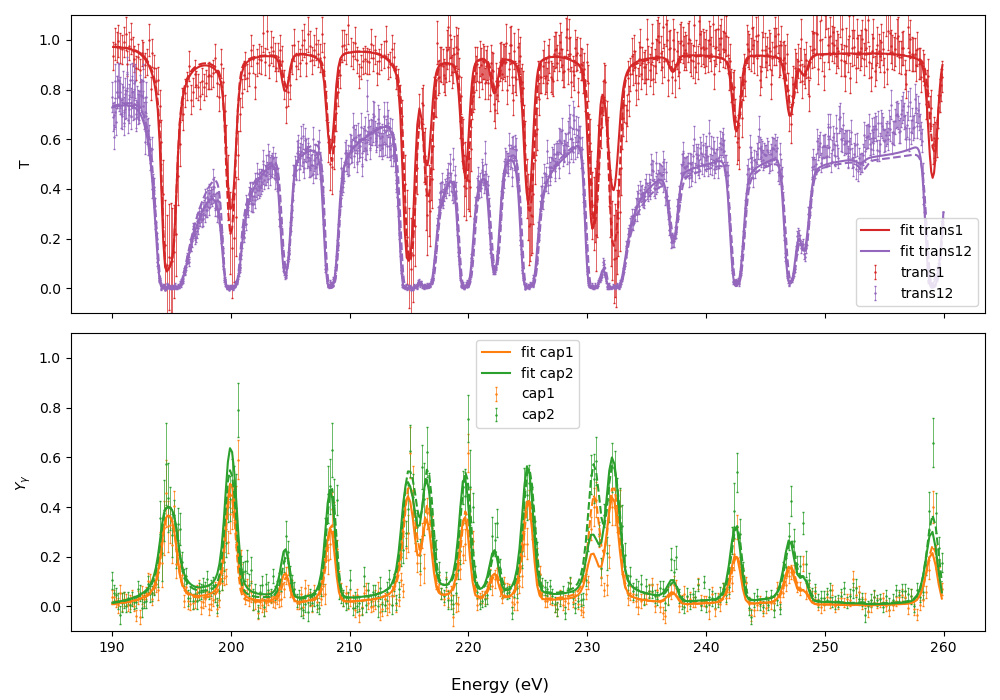

In [21]:
fig = plot(datasets, experiments, sammyOUT.pw_post, priors=sammyOUT.pw)
fig.tight_layout()

### Now, generate synthetic datasets modelled after each dataset you have

In [22]:
# from ATARI.theory.resonance_statistics import make_res_par_avg

# ac = 0.81271    # scattering radius in 1e-12 cm 
# M = 180.948030  # amu of target nucleus
# m = 1           # amu of incident neutron
# I = 3.5         # intrinsic spin, positive parity
# i = 0.5         # intrinsic spin, positive parity
# l_max = 1       # highest order l-wave to consider


# spin_groups = [ (3.0,1,0)]  # ,  (4.0,1,0)]
# res_par_avg_1 = make_res_par_avg(J_ID=1,
#                                  D_avg = 8.79, 
#                             Gn_avg= 46.4, #0.658, 
#                             n_dof = 1, 
#                             Gg_avg = 64.0, 
#                             g_dof = 1000, 
#                             print = False)

# res_par_avg_2 = make_res_par_avg(J_ID=2,
#                                  D_avg = 4.99, 
#                             Gn_avg= 35.5, #0.658, 
#                             n_dof = 1, 
#                             Gg_avg = 64.0, 
#                             g_dof = 1000, 
#                             print = False)

# average_parameters = {'3.0':res_par_avg_1}
# Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
#                                 input_options={},
#                                 spin_groups=spin_groups,
#                                 average_parameters=average_parameters )   


In [23]:
# from ATARI.syndat.transmission_rpi import syndat_T
# from ATARI.syndat.yield_rpi import syndat_Y

# ### In the future this code block will be inside of syndat 
# # Also, currently this is not sampling resonance parameters


# synthetic_data_dfs = []
# for i, exp in enumerate(experiments):

#     true_df = copy(sammyOUT.pw_post[i])
#     if exp.reaction == "transmission":
#         true = "theo_trans"
#         syndat = syndat_T()
#     elif exp.reaction == "capture":
#         true = "theo_xs"
#         syndat = syndat_Y()
#     else:
#         raise ValueError()

#     true_df = true_df[["E",true]]
#     true_df.rename(columns={true:"true"}, inplace=True)

#     syndat.run(true_df)
#     synthetic_data_dfs.append(syndat.data)

    

In [24]:

# fig, axes = subplots(2,1, figsize=(8,6), sharex=True)


# for i, exp in enumerate(experiments):
    
#     if exp.reaction == "transmission":

#         axes[0].errorbar(synthetic_data_dfs[i].E, synthetic_data_dfs[i].exp, yerr=synthetic_data_dfs[i].exp_unc, zorder=0,
#                                                 fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

#         axes[0].plot(synthetic_data_dfs[i].E, synthetic_data_dfs[i].true)
        
#     elif exp.reaction == "capture":
    
#         axes[1].errorbar(synthetic_data_dfs[i].E, synthetic_data_dfs[i].exp, yerr=synthetic_data_dfs[i].exp_unc, zorder=0, 
#                                                 fmt='.', color='indigo', linewidth=0.5, markersize=1.5, capsize=1, label='1mm')
#         axes[1].plot(synthetic_data_dfs[i].E, synthetic_data_dfs[i].true)


# axes[0].set_ylabel("T")
# axes[1].set_ylabel(r"$Y_{\gamma}$")

# ### make it pretty
# for ax in axes:
#     ax.set_xlim([200,250])
#     ax.set_ylim([-0.1,1.1])
#     ax.legend()

# fig.supxlabel('Energy (eV)')
# fig.tight_layout()

### Now fit synthetic or real data with automated evaluator

In [25]:
from ATARI.theory.resonance_statistics import make_res_par_avg

def get_parameter_grid(energy_grid, res_par_avg, num_Er, option=0):

    # allow Elambda to be just outside of the window
    max_Elam = max(energy_grid) + res_par_avg['Gt99']/10e3
    min_Elam = min(energy_grid) - res_par_avg['Gt99']/10e3

    if option == 1:
        Gn = np.repeat(res_par_avg["Gn01"], num_Er)*10
        Gg = np.repeat(res_par_avg["<Gg>"], num_Er)
    else:
        Gn = np.repeat(res_par_avg["Gn01"], num_Er)*1000
        Gg = np.repeat(res_par_avg["<Gg>"], num_Er)
        
    Er = np.linspace(              min_Elam,              max_Elam,                num_Er)
    J_ID = np.repeat(res_par_avg["J_ID"], num_Er)

    return Er, Gg, Gn, J_ID

def get_resonance_ladder(Er, Gg, Gn1, J_ID, varyE=1, varyGg=1, varyGn1=1):
    return pd.DataFrame({"E":Er, "Gg":Gg, "Gn1":Gn1, "varyE":np.ones(len(Er))*varyE, "varyGg":np.ones(len(Er))*varyGg, "varyGn1":np.ones(len(Er))*varyGn1 ,"J_ID":J_ID})

spin_groups = [ (3.0,1,0) ,  (4.0,1,0)]
res_par_avg_1 = make_res_par_avg(J_ID=1,
                            D_avg = 8.79, 
                            Gn_avg= 46.4, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = 1000, 
                            print = False)
res_par_avg_2 = make_res_par_avg(J_ID=2,
                            D_avg = 4.99, 
                            Gn_avg= 35.5, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = 1000, 
                            print = False)

ac = 0.81271; M = 180.948030; m = 1; I = 3.5; i = 0.5; l_max = 1 
average_parameters = {'3.0':res_par_avg_1, '4.0':res_par_avg_2}

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   

num_Er = 75
Er_1, Gg_1, Gn_1, J_ID_1 = get_parameter_grid([190,260], res_par_avg_1, num_Er, option=1)
Er_2, Gg_2, Gn_2, J_ID_2 = get_parameter_grid([190,260], res_par_avg_2, 0, option=1)

Er = np.concatenate([Er_1, Er_2])
Gg = np.concatenate([Gg_1, Gg_2])
Gn = np.concatenate([Gn_1, Gn_2])
J_ID = np.concatenate([J_ID_1, J_ID_2])
initial_reslad = get_resonance_ladder(Er, Gg, Gn, J_ID, varyE=0, varyGg=0, varyGn1=1)

In [26]:

sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    model = model, 
    resonance_ladder = initial_reslad,  

    datasets= datasets,
    templates= templates,
    experiments = experiments,
    
    max_steps = 15,
    iterations = 2,
    step_threshold = 0.1,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,
    initial_parameter_uncertainty = 1.0
    )


In [27]:
sammyOUT_fit = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1', 'cap2', 'trans1', 'trans12', 'sum']
0    1.0  : [7.67946, 9.63773, 4.64201, 2217.14, 2239.0991999999997]


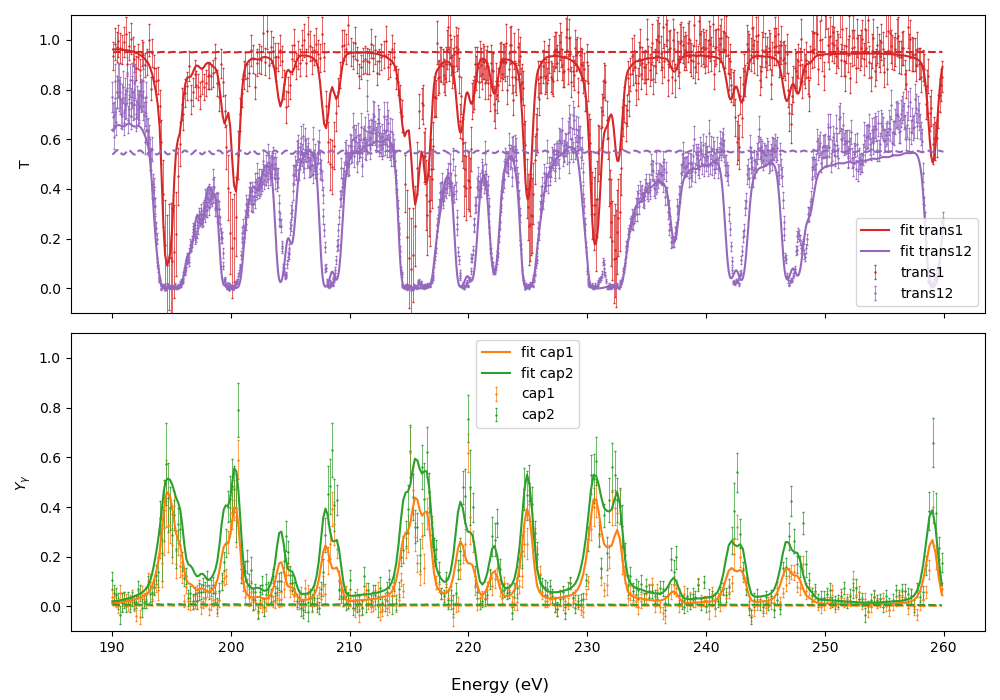

In [ ]:
fig = plot(datasets, experiments, sammyOUT_fit.pw_post, priors=sammyOUT_fit.pw)
fig.tight_layout()

In [ ]:

print(np.count_nonzero(sammyOUT_fit.par_post.Gn1>1e-1))
par2 =copy(sammyOUT_fit.par_post)
par2 = par2[par2.Gn1>1e-1]
par2["varyE"] = np.ones(len(par2))
par2["varyGg"] = np.ones(len(par2))
# par2

42


In [ ]:
sammyINPyw.resonance_ladder = par2
sammyOUT_fit2 = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1', 'cap2', 'trans1', 'trans12', 'sum']
0 1.0: [3.22408, 3.45746, 1.59399, 8.05877, 16.3343]
1 1.5: [2.56618, 2.59826, 1.21875, 4.39375, 10.77694]
2 2.25: [2.35962, 2.40304, 1.17071, 2.052, 7.98537]
decrease fudge, repeat step 3:
	1.5: [2.32859, 2.36157, 1.17621, 2.97807, 8.84444]
	1.0: [2.37331, 2.66753, 1.16318, 4.58257, 10.78659]
	0.6666666666666666: [2.40421, 2.56031, 1.22146, 5.41586, 11.601840000000001]
	0.4444444444444444: [2.57431, 2.61799, 1.39537, 41.6447, 48.23237]
	0.2962962962962963: [2.49956, 2.51213, 1.20547, 1.62541, 7.84257]
3 0.2962962962962963: [2.49956, 2.51213, 1.20547, 1.62541, 7.84257]
4 0.4444444444444444: [2.23516, 2.19012, 1.1587, 1.43857, 7.022550000000001]
decrease fudge, repeat step 5:
	0.2962962962962963: [2.19933, 2.16563, 1.12155, 1.59476, 7.08127]
	0.19753086419753085: [2.21566, 2.17943, 1.12743, 1.61755, 7.14007]
	0.1316872427983539: [2.22512, 2.18491, 1.13048, 1.49178, 7.03229]
	0.087791495198902

/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_17751/1060516316.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = subplots(2,1, figsize=(10,7), sharex=True)


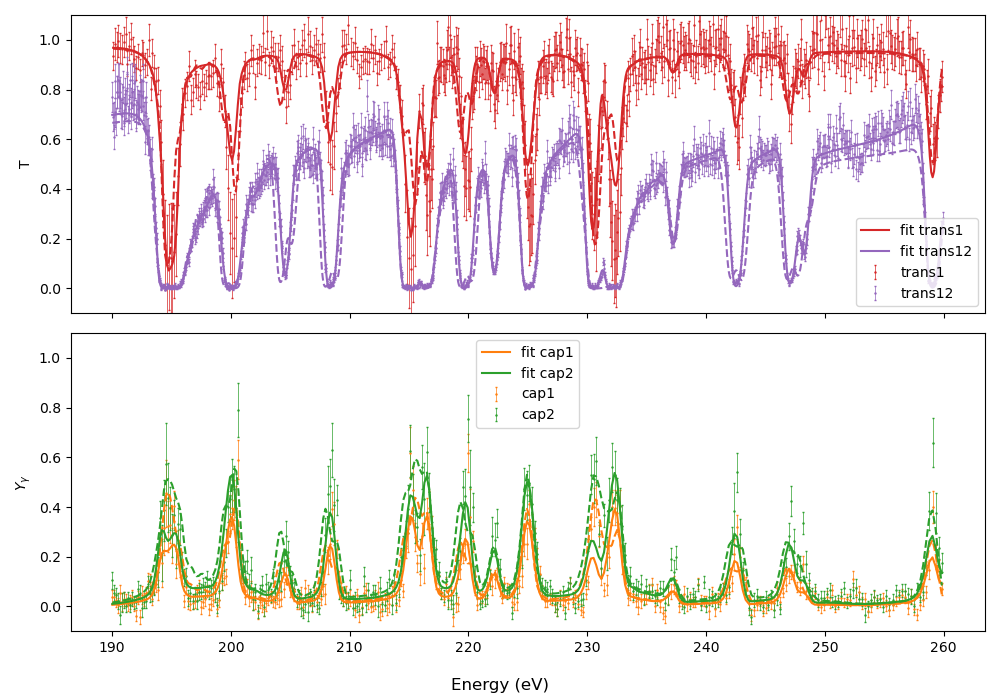

In [ ]:
fig = plot(datasets, experiments, sammyOUT_fit2.pw_post, priors=sammyOUT_fit2.pw)
fig.tight_layout()